In [1]:
import re
import os
import sys
import h5py
import time
import numpy as np
import scipy as sp
from utils import *
import mindspore as ms
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from mindquantum.framework import *
from mindquantum.core.gates import *
from scipy.stats import unitary_group
from mindquantum.core.circuit import *
from IPython.display import display_svg
from mindquantum.core.operators import *
from mindquantum.algorithm.nisq import *
from mindspore.common.initializer import *
from mindquantum.simulator import Simulator
from mindquantum.algorithm.compiler import *
from numpy.linalg import det, svd, eigh, norm
from scipy.linalg import expm, sqrtm, block_diag

np.set_printoptions(linewidth=200)

In [11]:
# Test whether a qudit encoding is in the symmetric subspace
d = 3
i1 = np.eye(d)
a1 = unitary_group.rvs(d)
# a1 = np.reshape(range(d**2), [d, d])
i2 = su2_encoding(i1)
a2 = su2_encoding(a1)
print(a1)
print(a2)
is_symmetric(a2)

[[ 0.29293776+0.43586909j  0.15994394+0.00700609j -0.81469807-0.18665881j]
 [-0.40723382-0.31847446j  0.82596818+0.12016911j -0.17205118+0.0804299j ]
 [-0.17108932-0.65396382j -0.33118218-0.40990629j -0.40783983-0.31467705j]]
[[ 0.29293776+0.43586909j  0.11309745+0.00495405j  0.11309745+0.00495405j -0.81469807-0.18665881j]
 [-0.2879578 -0.22519545j  0.41298409+0.06008456j  0.41298409+0.06008456j -0.12165856+0.05687253j]
 [-0.2879578 -0.22519545j  0.41298409+0.06008456j  0.41298409+0.06008456j -0.12165856+0.05687253j]
 [-0.17108932-0.65396382j -0.23418116-0.28984752j -0.23418116-0.28984752j -0.40783983-0.31467705j]]


True

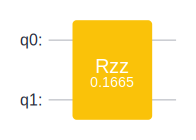

(True, True, True)

In [56]:
# U2U2 Rxx Ryy Rzz SWAP preserve symmetry
d = 3
a1 = unitary_group.rvs(d)
b1 = np.random.rand(d) + 1j * np.random.rand(d)
b1 /= norm(b1)
a2 = su2_encoding(a1)
b2 = su2_encoding(b1)
# print(a1)
# print(a2)
# print(b1)
# print(b2)
t = np.random.uniform(-np.pi, np.pi)
k = Circuit() + Rzz(t).on([0, 1])
# k = Circuit() + UN(UnivMathGate('', unitary_group.rvs(2)), 2)
display_svg(k.svg())
k = k.matrix()
# print(k)
# print(a2 @ k)
# print(k @ a2)
# print(k @ b2)
is_symmetric(a2 @ k), is_symmetric(k @ a2), is_symmetric(k @ b2)

In [12]:
# How to restore a reduce density matrix
np.random.seed(42)
a = np.random.rand(2) + 1j * np.random.rand(2)
b = np.random.rand(2) + 1j * np.random.rand(2)
a /= norm(a)
b /= norm(b)
psi_ab = np.kron(a, b)
rho_a = np.outer(a, a.conj())
rho_b = np.outer(b, b.conj())
rho_ab = np.kron(rho_a, rho_b)
print(rho_a)
print(rho_b)
print(rho_ab)
print(psi_ab.conj() @ rho_ab @ psi_ab)
fidelity(rho_ab, psi_ab)

[[0.34880034+0.j         0.40977999+0.24334959j]
 [0.40977999-0.24334959j 0.65119966+0.j        ]]
[[0.03454462+0.j         0.0930421 -0.15714469j]
 [0.0930421 +0.15714469j 0.96545538+0.j        ]]
[[ 1.20491735e-02+0.j          3.24531155e-02-0.05481212j  1.41556919e-02+0.00840642j  7.63678855e-02-0.04175299j]
 [ 3.24531155e-02+0.05481212j  3.36751167e-01+0.j         -1.14305675e-04+0.0870365j   3.95624296e-01+0.23494318j]
 [ 1.41556919e-02-0.00840642j -1.14305675e-04-0.0870365j   2.24954416e-02+0.j          6.05889828e-02-0.10233257j]
 [ 7.63678855e-02+0.04175299j  3.95624296e-01-0.23494318j  6.05889828e-02+0.10233257j  6.28704218e-01+0.j        ]]
(1.0000000000000007+0j)


1.0000000000000002